In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy
from shapely.geometry import point
import math

In [2]:
os.getcwd()

'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning'

In [3]:
#loading in the current enrollment for only the 2024-25 school year
current_enrollment = pd.read_csv(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\marketshare_output_pu_2324_848_gr_2021_2425_long.csv')
current_enrollment_2024 = current_enrollment[current_enrollment['year_str']=='2024-2025']
current_enrollment_2024.head()
current_enrollment_2024 = current_enrollment_2024.rename(columns = {'pu_2324_848':'pu_2324_84'})

In [4]:
#now we want to only show the 5th, 6th, 7th, and 8th grade - the grades that will be in high school in 2028-29
mask = current_enrollment_2024['grade'].isin([5,6,7,8])
hs_2028 = current_enrollment_2024[mask]
hs_2028 = hs_2028[['pu_2324_84','count','basez','lottery']]

In [5]:
#merging identical rows to get student counts by block and grade
columns_to_group = ['pu_2324_84']
hs_2028 = hs_2028.groupby(columns_to_group,as_index=False).sum() #as_index=False preserves the columns we are grouping by

#the planning units with zero enrollment are missing, so we must fill them with zeros
all_pus = pd.DataFrame({'pu_2324_84': range(1,849)})
hs_2028_full = all_pus.merge(hs_2028, on='pu_2324_84',how='left').fillna(0)
hs_2028_full

,pu_2324_84,count,basez,lottery
0,1,1.0,0.0,1.0
1,2,9.0,4.0,4.0
2,3,2.0,2.0,0.0
3,4,2.0,1.0,1.0
4,5,8.0,6.0,1.0
...,...,...,...,...
843,844,6.0,5.0,0.0
844,845,15.0,12.0,2.0
845,846,0.0,0.0,0.0
846,847,1.0,1.0,0.0


In [6]:
#read in the planning units
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\pu_2324_848.geojson').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu.head()

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
0,1,1,2.049028e+06,893128.606346,0.0,589,589,1,1,PU589,North,26532.120021,3.556198e+07,"MULTIPOLYGON (((-8.77e+06 4.33e+06, -8.77e+06 ..."
1,2,2,2.039923e+06,835434.121317,0.0,401,401,2,2,PU401,North,19333.085511,2.080136e+07,"MULTIPOLYGON (((-8.78e+06 4.31e+06, -8.78e+06 ..."
2,3,3,2.058005e+06,797649.028742,0.0,782,782.0,3,3,PU782.0,East,18314.823119,1.329077e+07,"MULTIPOLYGON (((-8.77e+06 4.29e+06, -8.77e+06 ..."
3,4,4,2.003222e+06,772895.737307,0.0,201,201.0,4,4,PU201.0,Southwest,29282.100083,4.684140e+07,"MULTIPOLYGON (((-8.79e+06 4.29e+06, -8.79e+06 ..."
4,5,5,2.067334e+06,828244.230730,0.0,646,646,6,6,PU646,East,60685.151474,1.497046e+08,"MULTIPOLYGON (((-8.77e+06 4.3e+06, -8.77e+06 4..."


In [7]:
#read in the school locations
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs

,OBJECTID,facilityid,sch_id6,sch_id,name,address,phone,agencyurl,operhours,spectype,...,region_base,region_physical,calendar_2324,calendar_2425,choice_2324,choice_2425,choice_2526,x_ncplane,y_ncplane,geometry
10,11,27253,320368,368,Southern High School,"800 Clayton Road Durham, NC 27703",919-560-3968,http://southern.dpsnc.net/pages/Southern_High,9:15am - 4:15pm,Magnet School,...,east,east,Traditional,Traditional,Energy & Sustainability,Energy & Sustainability,Energy & Sustainability,2050552.39,818903.23,POINT (-8.78e+06 4.3e+06)
14,15,87951,320325,325,Hillside High School,3727 Fayetteville Street Durham NC 27707,919-560-3925,http://hillside.dpsnc.net/pages/Hillside_High,9:15am - 4:15pm,None,...,southeast,southeast,Traditional,Traditional,International Baccalaureate,International Baccalaureate,International Baccalaureate,2028531.50,801909.91,POINT (-8.78e+06 4.29e+06)
55,56,6494,320356,356,Northern High School,4622 N Roxboro Road Durham NC 27712,919-560-3956,http://northern.dpsnc.net/pages/Northern_High,9:15am - 4:15pm,None,...,north,north,Traditional,Traditional,None,None,None,2029463.13,841220.63,POINT (-8.78e+06 4.31e+06)
56,57,12065,320365,365,Riverside High School,"3218 Rose of Sharon Road Durham, NC 27712",919-560-3965,http://www.edlinesites.net/pages/Riverside_High,9:15am - 4:15pm,None,...,central,north,Traditional,Traditional,None,None,None,2018531.26,843582.30,POINT (-8.79e+06 4.31e+06)
57,58,76194,320312,312,Jordan High School,6806 Garrett Road Durham NC 27707,919-560-3912,http://jordan.dpsnc.net/pages/Jordan_High,9:15am - 4:15pm,None,...,southwest,southwest,Traditional,Traditional,None,None,None,2011193.93,790759.00,POINT (-8.79e+06 4.29e+06)


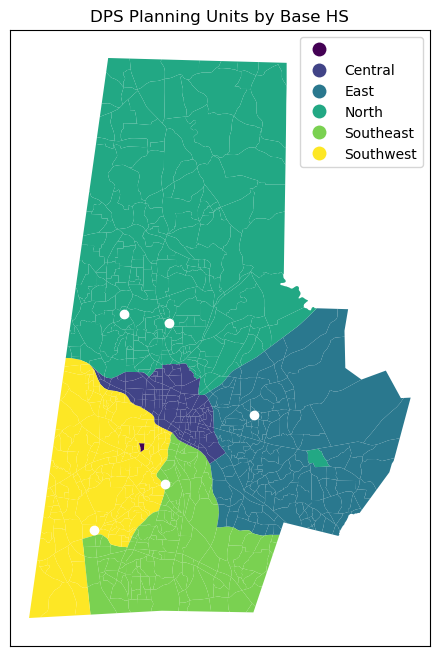

In [8]:
fig,ax = plt.subplots(figsize=(6,8))

dps_pu.plot(
    column = 'Region',
    legend = True,
    cmap = 'viridis',
    ax = ax
)
dps_base_hs.plot(ax=plt.gca(),zorder = 1, color = 'white')


ax.set_xticks([])
ax.set_yticks([])


plt.title('DPS Planning Units by Base HS')
plt.show()

In [9]:
hs_2028_geo = dps_pu.merge(hs_2028_full, on = 'pu_2324_84')[['pu_2324_84','X','Y','Region','Shape_Area','geometry','count','basez','lottery']]
#merge the student counts with the geometries
hs_2028_geo['centroid'] = hs_2028_geo['geometry'].centroid
hs_2028_geo.head()
#now we have the student counts and geometries for each planning unit

,pu_2324_84,X,Y,Region,Shape_Area,geometry,count,basez,lottery,centroid
0,1,2.049028e+06,893128.606346,North,3.556198e+07,"MULTIPOLYGON (((-8.77e+06 4.33e+06, -8.77e+06 ...",1.0,0.0,1.0,POINT (-8.78e+06 4.33e+06)
1,2,2.039923e+06,835434.121317,North,2.080136e+07,"MULTIPOLYGON (((-8.78e+06 4.31e+06, -8.78e+06 ...",9.0,4.0,4.0,POINT (-8.78e+06 4.31e+06)
2,3,2.058005e+06,797649.028742,East,1.329077e+07,"MULTIPOLYGON (((-8.77e+06 4.29e+06, -8.77e+06 ...",2.0,2.0,0.0,POINT (-8.77e+06 4.29e+06)
3,4,2.003222e+06,772895.737307,Southwest,4.684140e+07,"MULTIPOLYGON (((-8.79e+06 4.29e+06, -8.79e+06 ...",2.0,1.0,1.0,POINT (-8.79e+06 4.28e+06)
4,5,2.067334e+06,828244.230730,East,1.497046e+08,"MULTIPOLYGON (((-8.77e+06 4.3e+06, -8.77e+06 4...",8.0,6.0,1.0,POINT (-8.77e+06 4.3e+06)


<Axes: >

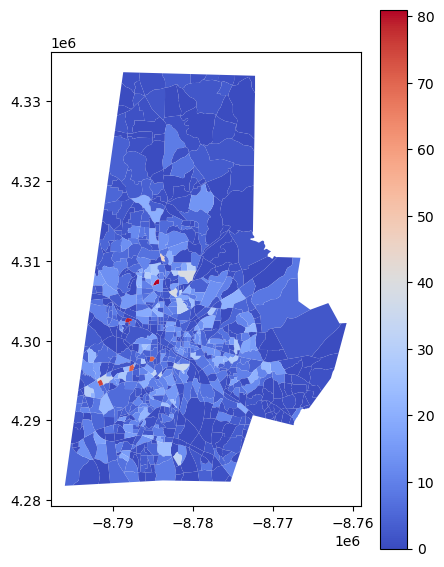

In [10]:
fig,ax = plt.subplots(figsize = (5,7))

hs_2028_geo.plot(
    column = 'basez',
    cmap = 'coolwarm',
    ax = ax,
    legend = True
)

In [ ]:
#goal counts:
#Southern: 1700, Hillside: 1700, Northern: 1700, Riverside: 1700, Jordan: 2000

In [42]:
#repeat until capacities in range
counts = pd.DataFrame([])
counts['capacity'] = [1700,1700,1700,1700,2000]
for i in range(0,100):
    counts['count']=[0,0,0,0,0]
    if i==0:
        counts['coefficient']=[1,1,1,1,1] 
    for pu in hs_2028_geo.index:
        centroid = hs_2028_geo.loc[pu,'centroid']
        num_students = hs_2028_geo.loc[pu,'count']
        [Southern, Hillside, Northern, Riverside, Jordan] = [dps_base_hs.iloc[0,28].distance(centroid)*counts.loc[0,'coefficient'], 
                                                             dps_base_hs.iloc[1,28].distance(centroid)*counts.loc[1,'coefficient'],
                                                             dps_base_hs.iloc[2,28].distance(centroid)*counts.loc[2,'coefficient'],
                                                             dps_base_hs.iloc[3,28].distance(centroid)*counts.loc[3,'coefficient'],
                                                             dps_base_hs.iloc[4,28].distance(centroid)*counts.loc[4,'coefficient']]
        distances = {'Southern':Southern,
                     'Hillside':Hillside,
                     'Northern':Northern,
                     'Riverside':Riverside,
                     'Jordan':Jordan}
            
        assign = min(distances, key = distances.get)
        if assign == 'Southern':
            counts.loc[0,'count']+=num_students
        if assign == 'Hillside':
            counts.loc[1,'count']+=num_students
        if assign == 'Northern':
            counts.loc[2,'count']+=num_students
        if assign == 'Riverside':
            counts.loc[3,'count']+=num_students
        if assign == 'Jordan':
            counts.loc[4,'count']+=num_students
        hs_2028_geo.loc[pu,'assign']=assign
    counts['coefficient'] = (counts['count']/counts['capacity'])**0.2
    

        
    #calculate coefficient outside for loop
    


In [43]:
counts

,capacity,count,coefficient
0,1700,1831,1.014958
1,1700,2370,1.068710
2,1700,1664,0.995728
3,1700,1181,0.929737
4,2000,1729,0.971299


<Axes: >

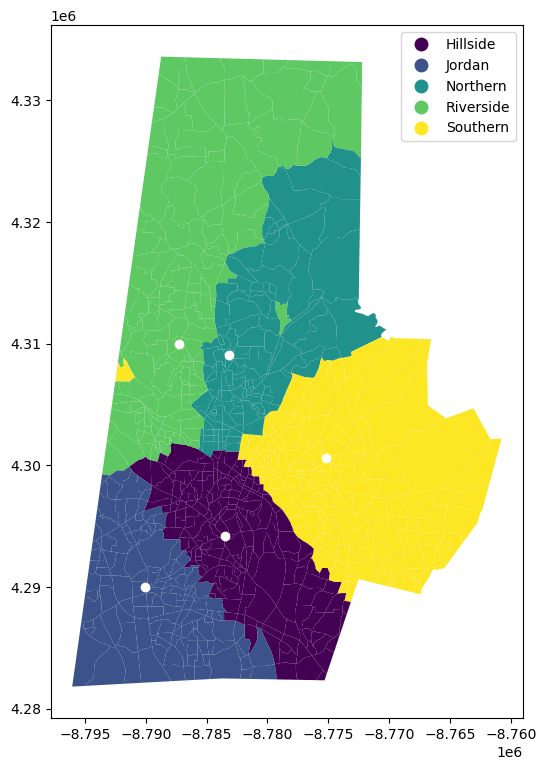

In [44]:
fig,ax = plt.subplots(figsize = (7,9))

hs_2028_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)
dps_base_hs.plot(ax=plt.gca(), color = 'white')